In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import matplotlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
# 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
# 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67

# Скачиваем данные

In [228]:
def read_file(file):
    df = pd.read_csv(file)
    df = df.drop_duplicates()
    #print(df.shape)
    
    return df

In [229]:
df = read_file(f'data.csv')
df = df.drop_duplicates()
df.shape

(21613, 22)

In [230]:
df = df.drop(
    [
        df.columns[0],
        'id',
        'date'
    ], 
    axis=1
)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,0,1955,0,98178,47.511200,-122.257000,1340,5650
1,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,400,1951,1991,98125,47.721000,-122.319000,1690,7639
2,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,0,1933,0,98028,47.737900,-122.233000,2720,8062
3,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,910,1965,0,98136,47.520800,-122.393000,1360,5000
4,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,0,1987,0,98074,47.616800,-122.045000,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.000000,3,2.500000,1530,1131,3.000000,0,0,3,8,1530,0,2009,0,98103,47.699300,-122.346000,1530,1509
21609,400000.000000,4,2.500000,2310,5813,2.000000,0,0,3,8,2310,0,2014,0,98146,47.510700,-122.362000,1830,7200
21610,402101.000000,2,0.750000,1020,1350,2.000000,0,0,3,7,1020,0,2009,0,98144,47.594400,-122.299000,1020,2007
21611,400000.000000,3,2.500000,1600,2388,2.000000,0,0,3,8,1600,0,2004,0,98027,47.534500,-122.069000,1410,1287


# 1.Обработка данных

In [231]:
def get_cols(df) -> list:
    '''
    функция возвращает список категориальных и числовых переменных
    '''
    categorical_feature_mask = df.dtypes == object
    number_feature_mask = df.dtypes != object
    numbers_cols = df.columns[number_feature_mask].tolist()
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    return [numbers_cols, categorical_cols]

In [232]:
# смотрим на пропущенные значения в % и отберем все стобцы, где пропущены данные < 0.2% от общего количества 
cols = df.apply(lambda x: f'{(x.isna().sum()/df.shape[0]).round(2)} %').sort_values()[:-4].index.to_list()

df.sample(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14579,719000.000000,3,1.750000,1800,5816,1.000000,0,0,5,7,900,900,1947,0,98199,47.652900,-122.407000,1650,5816


In [233]:
numbers_cols, categorical_cols = get_cols(df)

In [234]:
#смотрим на пропущенные числовые значения
df[numbers_cols].apply(lambda x: x.isna().sum())

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [235]:
# меняем пропущенные числовые признаки на их среднее по столбцу
for col in df[numbers_cols].columns.to_list():
    df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype('float')

### работаем с исходными столбцами, иницализируем составные переменные, удаляем дубликаты

In [236]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.000000,3.000000,1.000000,1180.000000,5650.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1955.000000,0.000000,98178.000000,47.511200,-122.257000,1340.000000,5650.000000
1,538000.000000,3.000000,2.250000,2570.000000,7242.000000,2.000000,0.000000,0.000000,3.000000,7.000000,2170.000000,400.000000,1951.000000,1991.000000,98125.000000,47.721000,-122.319000,1690.000000,7639.000000
2,180000.000000,2.000000,1.000000,770.000000,10000.000000,1.000000,0.000000,0.000000,3.000000,6.000000,770.000000,0.000000,1933.000000,0.000000,98028.000000,47.737900,-122.233000,2720.000000,8062.000000
3,604000.000000,4.000000,3.000000,1960.000000,5000.000000,1.000000,0.000000,0.000000,5.000000,7.000000,1050.000000,910.000000,1965.000000,0.000000,98136.000000,47.520800,-122.393000,1360.000000,5000.000000
4,510000.000000,3.000000,2.000000,1680.000000,8080.000000,1.000000,0.000000,0.000000,3.000000,8.000000,1680.000000,0.000000,1987.000000,0.000000,98074.000000,47.616800,-122.045000,1800.000000,7503.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.000000,3.000000,2.500000,1530.000000,1131.000000,3.000000,0.000000,0.000000,3.000000,8.000000,1530.000000,0.000000,2009.000000,0.000000,98103.000000,47.699300,-122.346000,1530.000000,1509.000000
21609,400000.000000,4.000000,2.500000,2310.000000,5813.000000,2.000000,0.000000,0.000000,3.000000,8.000000,2310.000000,0.000000,2014.000000,0.000000,98146.000000,47.510700,-122.362000,1830.000000,7200.000000
21610,402101.000000,2.000000,0.750000,1020.000000,1350.000000,2.000000,0.000000,0.000000,3.000000,7.000000,1020.000000,0.000000,2009.000000,0.000000,98144.000000,47.594400,-122.299000,1020.000000,2007.000000
21611,400000.000000,3.000000,2.500000,1600.000000,2388.000000,2.000000,0.000000,0.000000,3.000000,8.000000,1600.000000,0.000000,2004.000000,0.000000,98027.000000,47.534500,-122.069000,1410.000000,1287.000000


In [237]:
df = df.rename(
    columns = {
        'id': 'идентификатор',
        'price': 'цена',
        'bedrooms': 'количество спален',
        'bathrooms': 'количество ванных комнат',
        'sqft_living': 'жилая площадь (кв. футы)',
        'sqft_lot': 'площадь участка (кв. футы)',
        'floors': 'количество этажей',
        'waterfront': 'водная поверхность (1, если дом находится на берегу, иначе 0)',
        'view': 'вид на собственность (от 0 до 4)',
        'condition': 'состояние объекта (от 1 до 5)',
        'grade': 'класс объекта (от 1 до 13)',
        'sqft_above': 'площадь над уровнем земли (кв. футы)',
        'sqft_basement': 'площадь подвала (кв. футы)',
        'yr_built': 'год постройки',
        'yr_renovated': 'год реновации',
        'zipcode': 'почтовый индекс',
        'lat': 'широта',
        'long': 'долгота',
        'sqft_living15': 'средняя жилая площадь ближайших 15 соседей (кв. футы)',
        'sqft_lot15': 'средняя площадь участков ближайших 15 соседей (кв. футы)'
    }
)

In [238]:
df.columns

Index(['цена', 'количество спален', 'количество ванных комнат',
       'жилая площадь (кв. футы)', 'площадь участка (кв. футы)',
       'количество этажей',
       'водная поверхность (1, если дом находится на берегу, иначе 0)',
       'вид на собственность (от 0 до 4)', 'состояние объекта (от 1 до 5)',
       'класс объекта (от 1 до 13)', 'площадь над уровнем земли (кв. футы)',
       'площадь подвала (кв. футы)', 'год постройки', 'год реновации',
       'почтовый индекс', 'широта', 'долгота',
       'средняя жилая площадь ближайших 15 соседей (кв. футы)',
       'средняя площадь участков ближайших 15 соседей (кв. футы)'],
      dtype='object')

In [239]:
df.to_csv('data_res.csv')

# 2.Визуализация данных

In [240]:
df

,цена,количество спален,количество ванных комнат,жилая площадь (кв. футы),площадь участка (кв. футы),количество этажей,"водная поверхность (1, если дом находится на берегу, иначе 0)",вид на собственность (от 0 до 4),состояние объекта (от 1 до 5),класс объекта (от 1 до 13),площадь над уровнем земли (кв. футы),площадь подвала (кв. футы),год постройки,год реновации,почтовый индекс,широта,долгота,средняя жилая площадь ближайших 15 соседей (кв. футы),средняя площадь участков ближайших 15 соседей (кв. футы)
0,221900.000000,3.000000,1.000000,1180.000000,5650.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1955.000000,0.000000,98178.000000,47.511200,-122.257000,1340.000000,5650.000000
1,538000.000000,3.000000,2.250000,2570.000000,7242.000000,2.000000,0.000000,0.000000,3.000000,7.000000,2170.000000,400.000000,1951.000000,1991.000000,98125.000000,47.721000,-122.319000,1690.000000,7639.000000
2,180000.000000,2.000000,1.000000,770.000000,10000.000000,1.000000,0.000000,0.000000,3.000000,6.000000,770.000000,0.000000,1933.000000,0.000000,98028.000000,47.737900,-122.233000,2720.000000,8062.000000
3,604000.000000,4.000000,3.000000,1960.000000,5000.000000,1.000000,0.000000,0.000000,5.000000,7.000000,1050.000000,910.000000,1965.000000,0.000000,98136.000000,47.520800,-122.393000,1360.000000,5000.000000
4,510000.000000,3.000000,2.000000,1680.000000,8080.000000,1.000000,0.000000,0.000000,3.000000,8.000000,1680.000000,0.000000,1987.000000,0.000000,98074.000000,47.616800,-122.045000,1800.000000,7503.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.000000,3.000000,2.500000,1530.000000,1131.000000,3.000000,0.000000,0.000000,3.000000,8.000000,1530.000000,0.000000,2009.000000,0.000000,98103.000000,47.699300,-122.346000,1530.000000,1509.000000
21609,400000.000000,4.000000,2.500000,2310.000000,5813.000000,2.000000,0.000000,0.000000,3.000000,8.000000,2310.000000,0.000000,2014.000000,0.000000,98146.000000,47.510700,-122.362000,1830.000000,7200.000000
21610,402101.000000,2.000000,0.750000,1020.000000,1350.000000,2.000000,0.000000,0.000000,3.000000,7.000000,1020.000000,0.000000,2009.000000,0.000000,98144.000000,47.594400,-122.299000,1020.000000,2007.000000
21611,400000.000000,3.000000,2.500000,1600.000000,2388.000000,2.000000,0.000000,0.000000,3.000000,8.000000,1600.000000,0.000000,2004.000000,0.000000,98027.000000,47.534500,-122.069000,1410.000000,1287.000000


<Axes: title={'center': 'Распредление данных по типам'}, ylabel='count'>

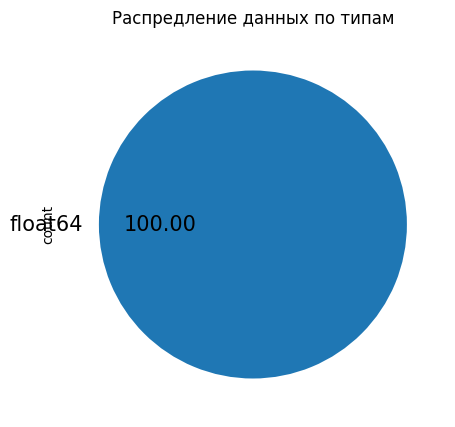

In [241]:
pd.Series([df[i].dtype for i in df.columns])\
                                .value_counts()\
                                .plot(
                                    kind = 'pie', autopct="%.2f",
                                    title = 'Распредление данных по типам',
                                    fontsize=15,
                                    figsize=(5, 5))

In [242]:
df['класс объекта (от 1 до 13)'].unique()

array([ 7.,  6.,  8., 11.,  9.,  5., 10., 12.,  4.,  3., 13.,  1.])

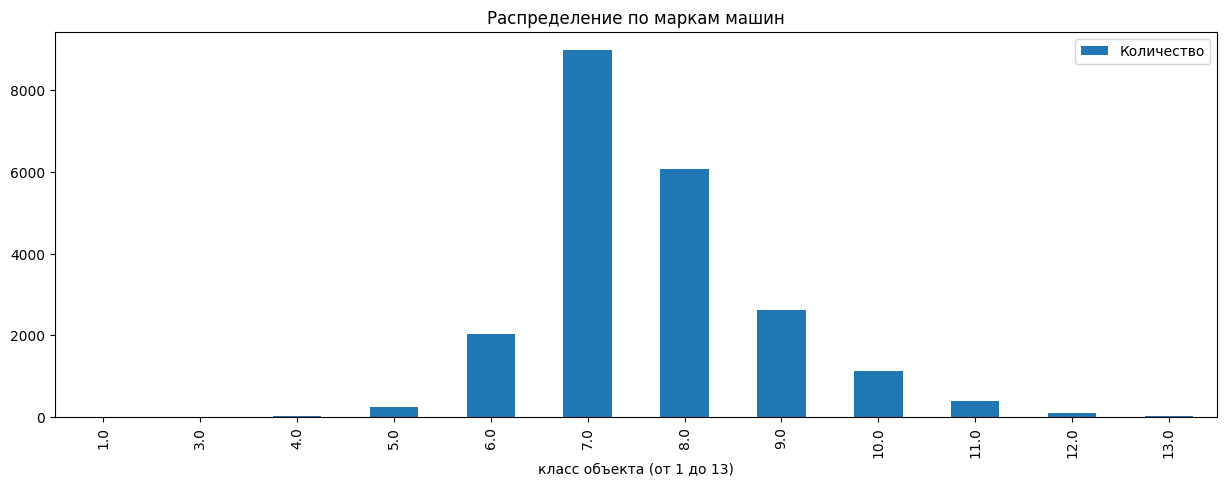

In [243]:
plt.figure(figsize=(16,8))
df.groupby(['класс объекта (от 1 до 13)']).size().plot(kind = 'bar',figsize=(15,5), title = 'Распределение по маркам машин', label = 'Количество')
plt.legend()

In [244]:
def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-6)
fmtr = matplotlib.ticker.FuncFormatter(millions)

Медианная стоимость квартир составила 450000


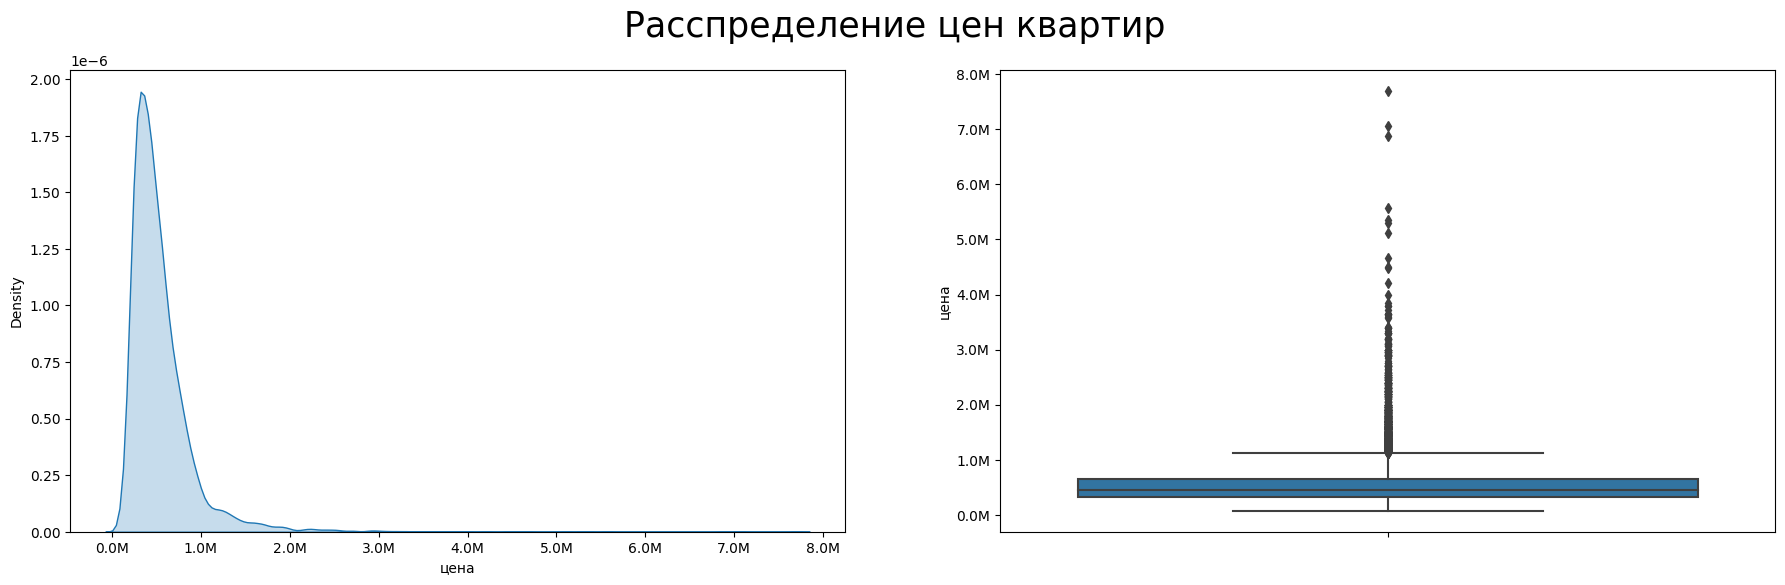

In [245]:
print(f'Медианная стоимость квартир составила {int(df.цена.median())}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))

plt.subplot(1,2,1)
ax = sns.kdeplot(df.цена, shade=True)
_ = ax.xaxis.set_major_formatter(fmtr)

plt.subplot(1,2,2)
ax = sns.boxplot(y=df.цена)
_ = ax.yaxis.set_major_formatter(fmtr)

fig.suptitle("Расспределение цен квартир",fontsize=25)
plt.show()

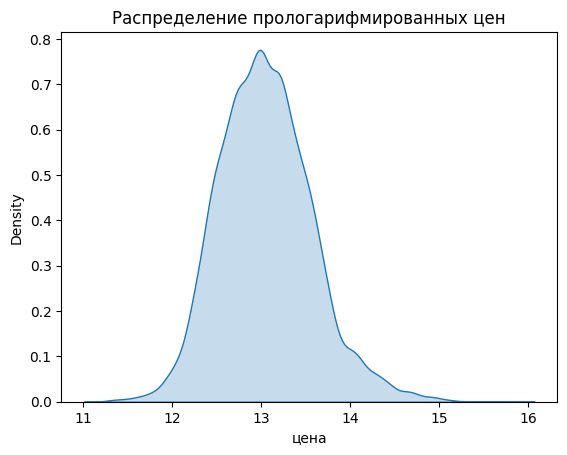

In [246]:
sns.kdeplot(np.log(df.цена), shade=True)
plt.title('Распределение прологарифмированных цен')
plt.show()

In [247]:
numbers_cols, categorical_cols = get_cols(df)

for column in categorical_cols:
    
    columne_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index
    
    if '' in columne_most_freq:
        columne_most_freq = columne_most_freq.drop('')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))    
    
    plt.subplot(1,2,1)
    plt.title(f'{column} Histogram')
    sns.countplot(
            df[df[column].isin(columne_most_freq)][column],
            order=columne_most_freq
    )
    
    plt.xticks(rotation=45)

    plt.subplot(1,2,2)
    plt.title(f'{column} vs Log Price')
    ax = sns.boxplot(
            x=df[df[column].isin(columne_most_freq)][column], 
            y=np.log(df[df[column].isin(columne_most_freq)].Цена), 
            order=columne_most_freq
    )
    plt.xticks(rotation=45)

    plt.show()

In [248]:
len(numbers_cols)

19

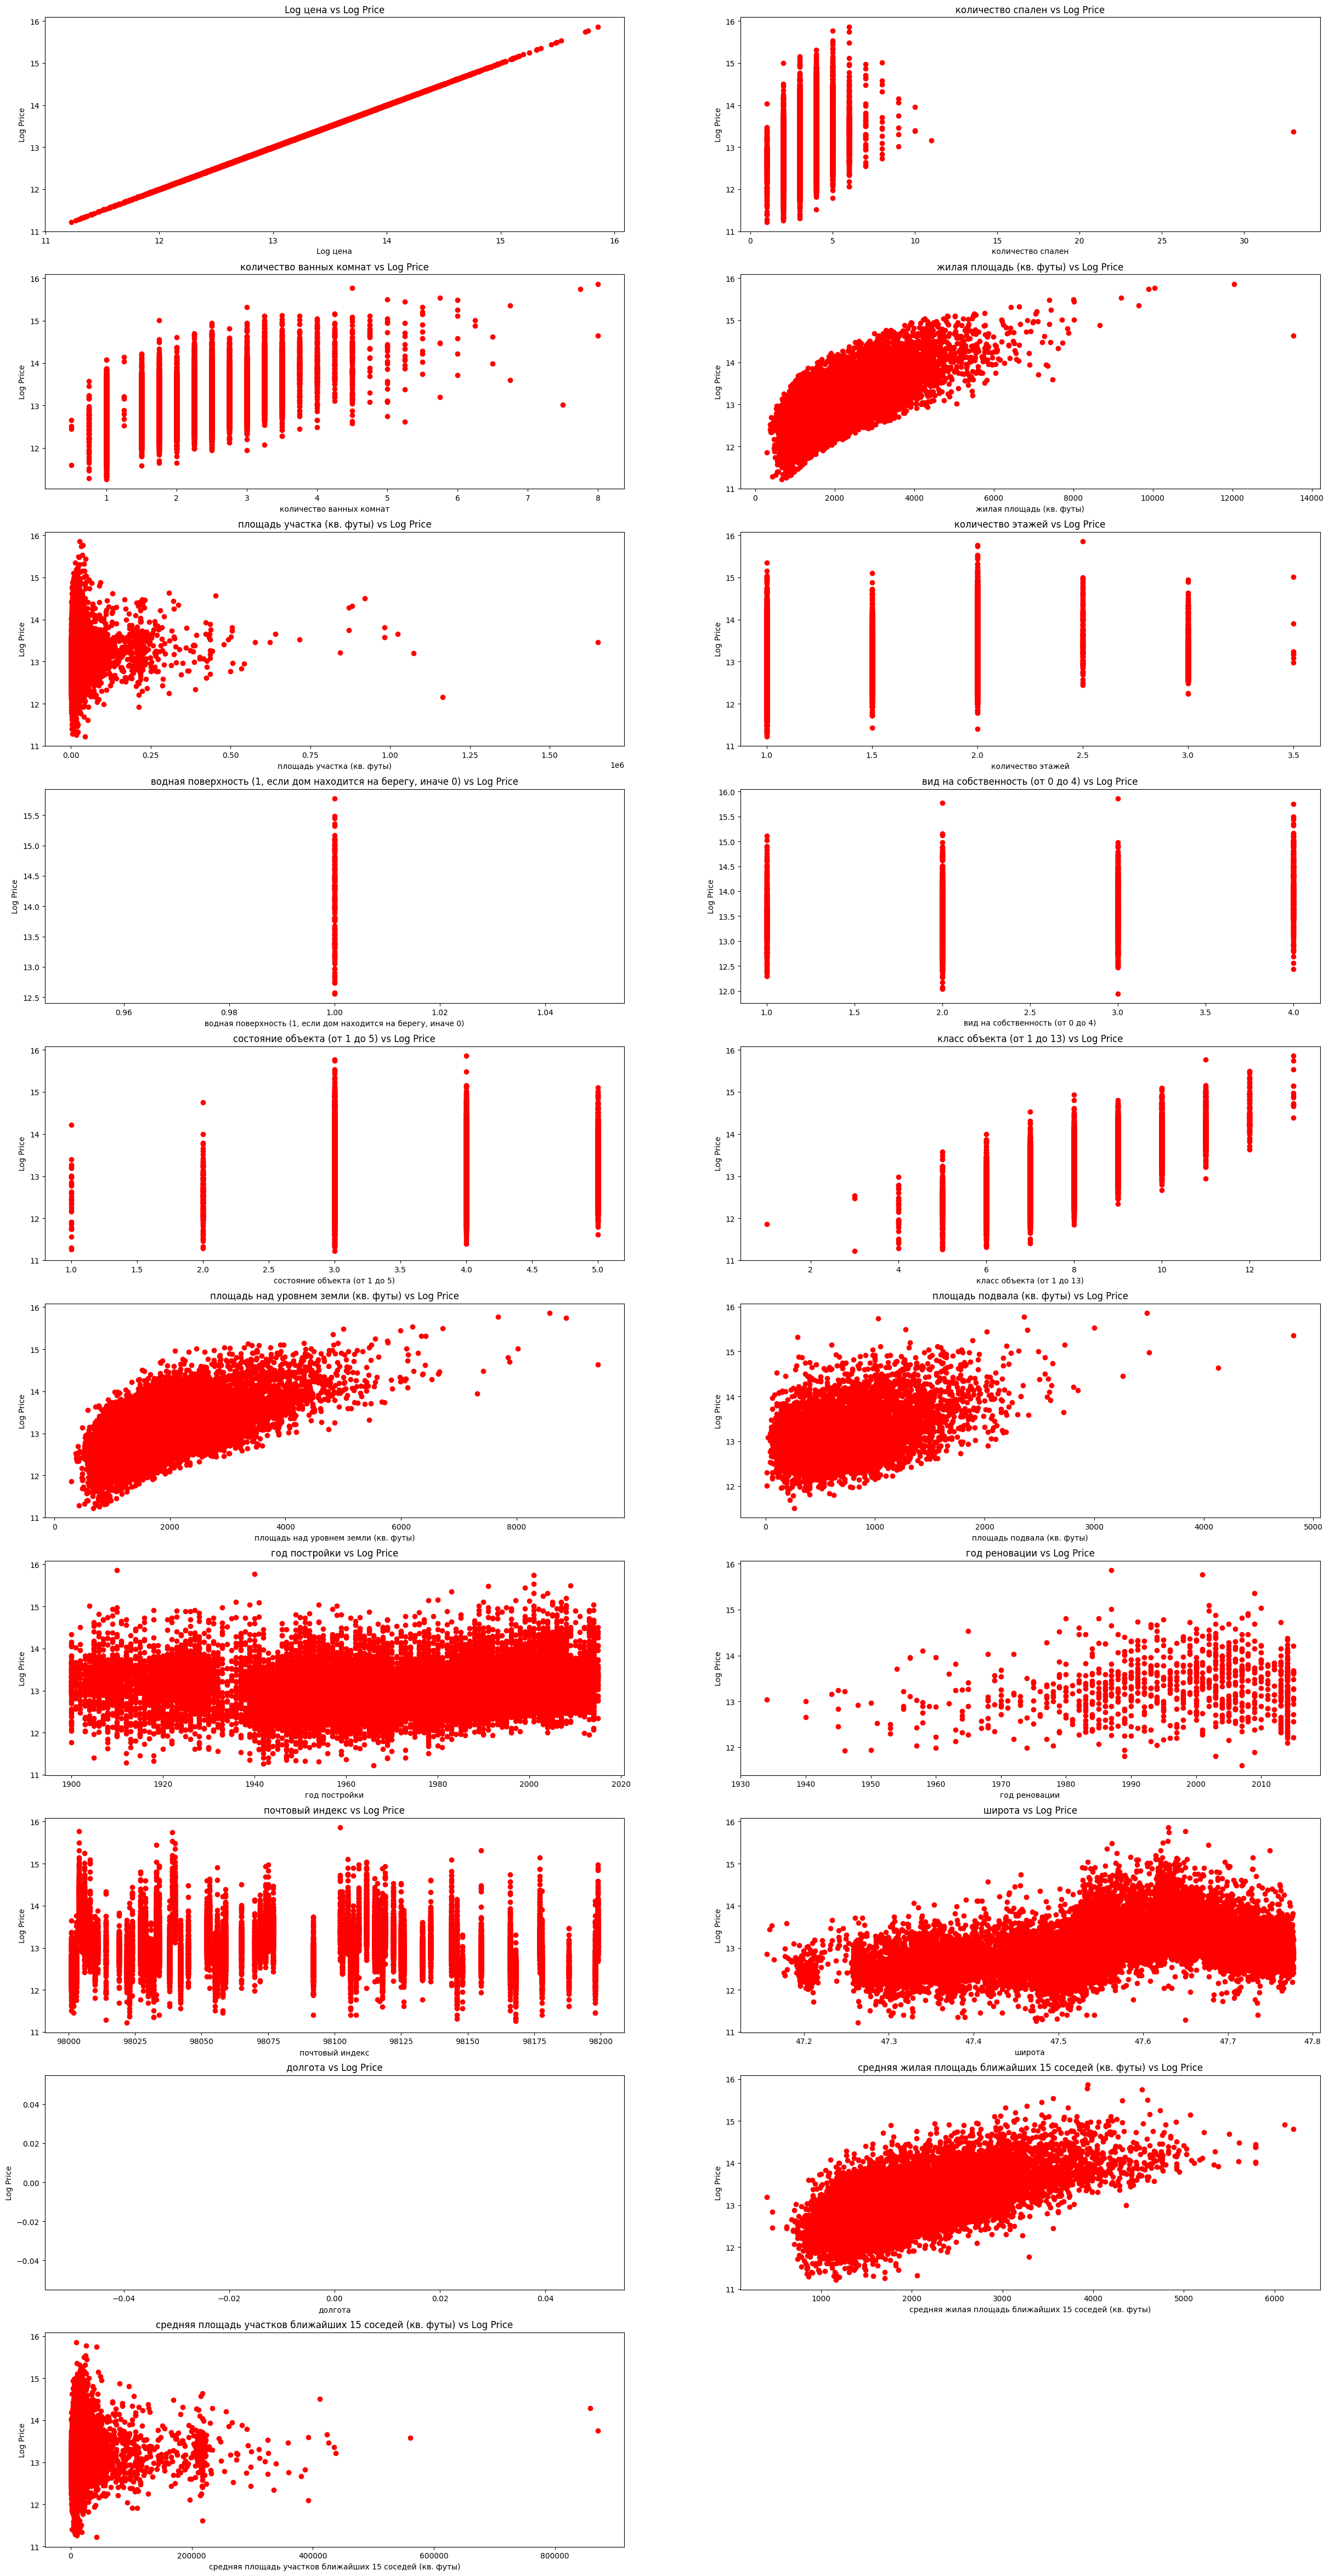

In [249]:
def scatter(column,fig):
    plt.subplot(33,2,fig)
    ax = plt.scatter(
        x=[price if 'цена' not in column else np.log(price) for price in df[df[column] > 0][column]],
        y=np.log(df[df[column] > 0].цена),
        color = 'red'
    )
    plt.title(f'{column} vs Log Price', fontsize=40)
    plt.title(f'{column} vs Log Price' if 'цена' not in column else f'Log {column} vs Log Price')
    plt.ylabel('Log Price')
    plt.xlabel(column if 'цена' not in column else f'Log {column}')

plt.figure(figsize=(30,200))

for i, column in enumerate(numbers_cols):
    scatter(column, i + 1)


# Описательная статистика

In [250]:
df.describe()

,цена,количество спален,количество ванных комнат,жилая площадь (кв. футы),площадь участка (кв. футы),количество этажей,"водная поверхность (1, если дом находится на берегу, иначе 0)",вид на собственность (от 0 до 4),состояние объекта (от 1 до 5),класс объекта (от 1 до 13),площадь над уровнем земли (кв. футы),площадь подвала (кв. футы),год постройки,год реновации,почтовый индекс,широта,долгота,средняя жилая площадь ближайших 15 соседей (кв. футы),средняя площадь участков ближайших 15 соседей (кв. футы)
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,540088.141767,3.370842,2.114757,2079.899736,15106.967566,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,367127.196483,0.930062,0.770163,918.440897,41420.511515,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,75000.000000,0.000000,0.000000,290.000000,520.000000,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,321950.000000,3.000000,1.750000,1427.000000,5040.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,450000.000000,3.000000,2.250000,1910.000000,7618.000000,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,645000.000000,4.000000,2.500000,2550.000000,10688.000000,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7700000.000000,33.000000,8.000000,13540.000000,1651359.000000,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<Axes: >

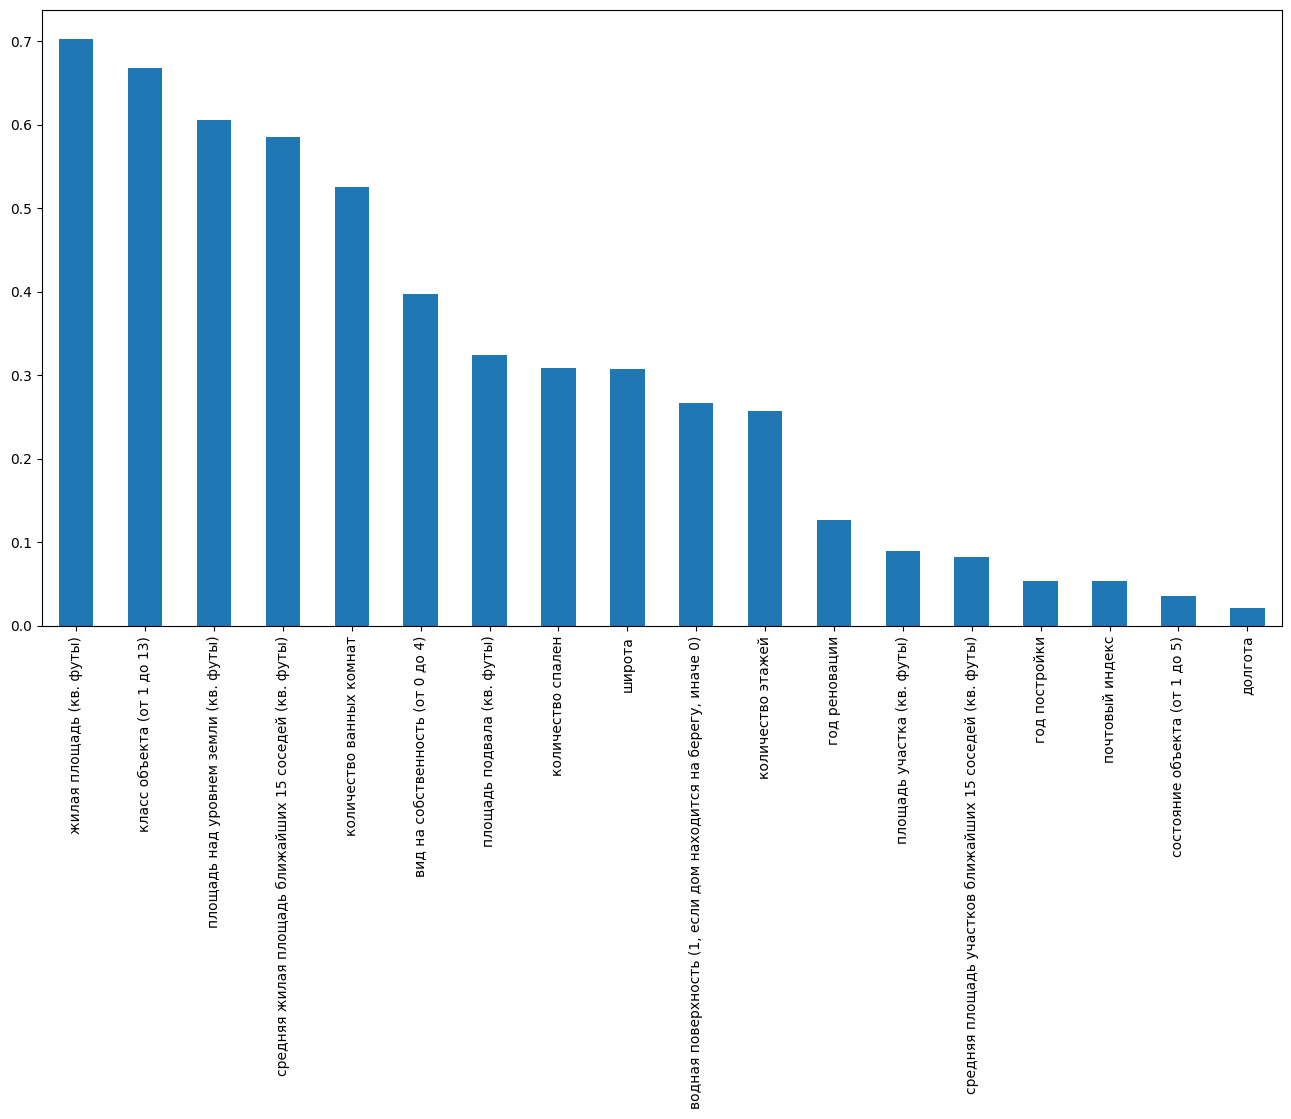

In [251]:
# корреляция признаков
plt.figure(figsize=(16,8))
abs(df.corr()['цена']).sort_values(ascending = False)[1:].plot(kind = 'bar')

# Модель OLS

In [252]:
numbers_cols, categorical_cols = get_cols(df)

sc = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda x: sc.fit_transform(x.astype(str)))

In [253]:
import statsmodels.api as sm

X = df.drop(['цена'], axis = 1).values
y = np.log(df['цена']).values

#линейная регрессия
res = sm.OLS(y, X)
res = res.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.400e+06
Date:                Tue, 09 May 2023   Prob (F-statistic):                        0.00
Time:                        19:36:11   Log-Likelihood:                         -907.78
No. Observations:               21613   AIC:                                      1850.
Df Residuals:                   21596   BIC:                                      1985.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0124      0.002     -5.235      0.000      -0.017      -0.008
x2             0.0692      0.004     16.954      0.000       0.061       0.077
x3          9.587e-05   2.85e-06     33.693      0.000    9.03e-05       0.000
x4          4.676e-07   6.01e-08      7.785      0.000     3.5e-07    5.85e-07
x5             0.0762      0.004     17.163      0.000       0.068       0.085
x6             0.3709      0.022     17.034      0.000       0.328       0.414
x7             0.0608      0.003     22.774      0.000       0.056       0.066
x8             0.0620      0.003     21.275      0.000       0.056       0.068
x9             0.1592      0.003     59.175      0.000       0.154       0.165
x10         3.976e-05   2.81e-06     14.166      0.000    3.43e-05    4.53e-05
x11         5.611e-05   3.29e-06     17.046      0.000    4.97e-05    6.26e-05
x12           -0.0035   8.53e-05    -40.502      0.000      -0.004      -0.003
x13         3.613e-05   4.57e-06      7.900      0.000    2.72e-05    4.51e-05
x14           -0.0007   2.24e-05    -31.035      0.000      -0.001      -0.001
x15            1.4004      0.013    104.025      0.000       1.374       1.427
x16           -0.1568      0.016     -9.568      0.000      -0.189      -0.125
x17         9.749e-05   4.25e-06     22.917      0.000    8.92e-05       0.000
x18         -2.66e-07   9.18e-08     -2.896      0.004   -4.46e-07   -8.59e-08
==============================================================================
Omnibus:                      371.747   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              753.763
Skew:                          -0.030   Prob(JB):                    2.10e-164
Kurtosis:                       3.913   Cond. No.                     4.96e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.9e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [254]:
def find_prediction_at_instance_for_ols(X, params, instance):
    return sum([val*X[instance, i].sum() for i, val in enumerate(params[:-1])])

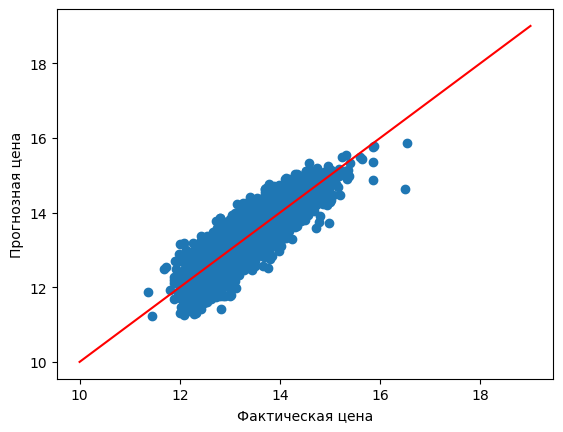

In [255]:
fig.set_size_inches(18.5, 10.5)
plt.scatter(
    [find_prediction_at_instance_for_ols(X, res.params, i) for i in range(X.shape[0])],
    np.log(df.цена))
plt.plot(list(range(10, 20)),list(range(10, 20)), c = 'red')
plt.xlabel('Фактическая цена')
plt.ylabel('Прогнозная цена')
plt.show()

In [256]:
res.predict(X)

array([12.51933869, 13.33752886, 12.94662165, ..., 12.49686963,
       12.86068699, 12.49994908])

In [257]:
r2_score(y, np.exp(res.predict(X)))

-1465185898572.3823

In [258]:
print(f'R^2: {res.rsquared_adj}')

R^2: 0.9996262623473354


In [259]:
cols = df.columns.to_list()
cols.remove('цена')

In [260]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [261]:
ols = pd.DataFrame()
ols['feature'] = cols
ols['coefs'] = abs(res.params)
ols['p_value'] = res.pvalues
ols.sort_values(by = 'coefs')

,feature,coefs,p_value
17,средняя площадь участков ближайших 15 соседей ...,0.000000,0.003785
3,площадь участка (кв. футы),0.000000,0.000000
12,год реновации,0.000036,0.000000
9,площадь над уровнем земли (кв. футы),0.000040,0.000000
10,площадь подвала (кв. футы),0.000056,0.000000
2,жилая площадь (кв. футы),0.000096,0.000000
16,средняя жилая площадь ближайших 15 соседей (кв...,0.000097,0.000000
13,почтовый индекс,0.000694,0.000000
11,год постройки,0.003455,0.000000
0,количество спален,0.012402,0.000000


In [262]:
data = df
X = data.drop(['цена'], axis = 1)
y = data.цена

In [263]:
prediction = pd.DataFrame()
prediction['pred'] = np.exp(res.predict(X))
prediction['fact'] = y
prediction['abs'] = abs(prediction['fact'] - prediction['pred'])

In [264]:
prediction.T

,0,1,2,3,4,5,6,7,8,9,...,21603,21604,21605,21606,21607,21608,21609,21610,21611,21612
pred,273577.081512,620033.547266,419417.301579,408884.364723,415544.875443,1849160.404381,283350.812766,241313.372121,319576.893382,294741.163475,...,437780.213317,382324.696557,525722.685802,659699.986800,381867.601668,510261.572879,392791.760573,267498.603572,384880.045422,268323.624197
fact,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000,1225000.000000,257500.000000,291850.000000,229500.000000,323000.000000,...,507250.000000,429000.000000,610685.000000,1007500.000000,475000.000000,360000.000000,400000.000000,402101.000000,400000.000000,325000.000000
abs,51677.081512,82033.547266,239417.301579,195115.635277,94455.124557,624160.404381,25850.812766,50536.627879,90076.893382,28258.836525,...,69469.786683,46675.303443,84962.314198,347800.013200,93132.398332,150261.572879,7208.239427,134602.396428,15119.954578,56676.375803


In [265]:
def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-7)
fmtr = matplotlib.ticker.FuncFormatter(millions)

OLS score = 0.6837096762640604


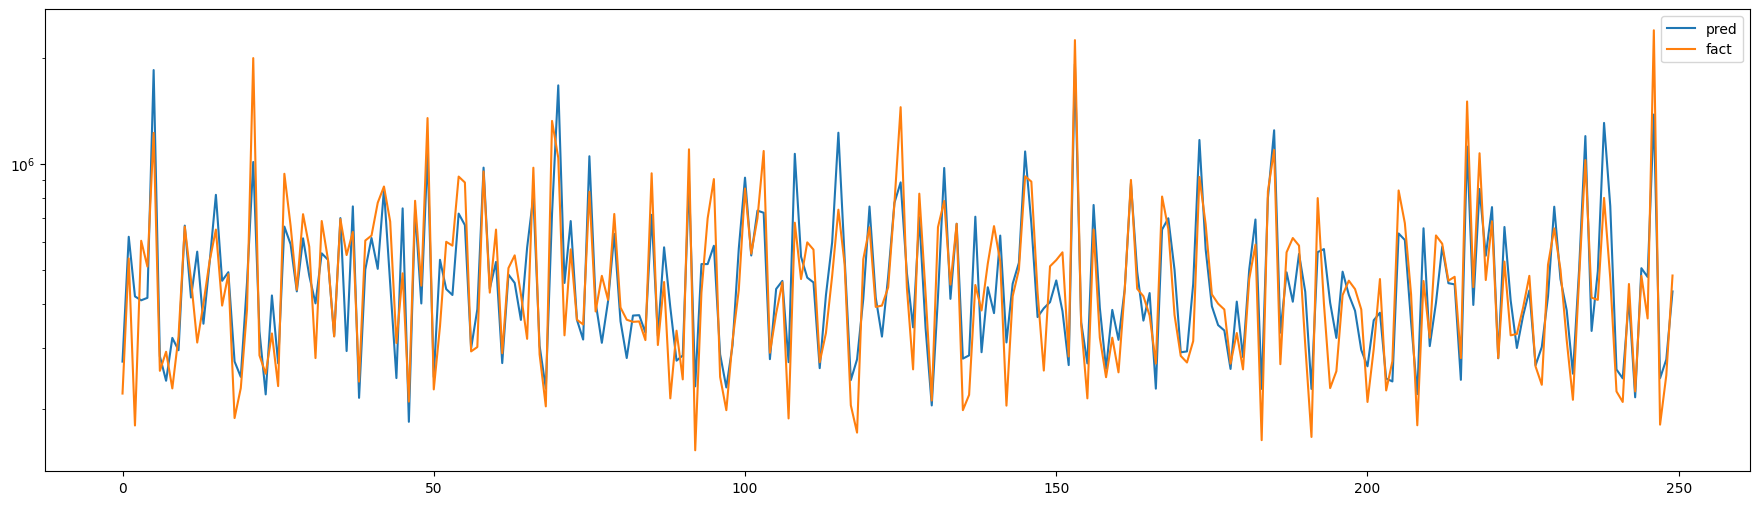

In [268]:
from sklearn.metrics import r2_score

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

plt.plot(range(250), prediction['pred'][:250], label = 'pred')
plt.plot(range(250), prediction['fact'][:250], label = 'fact')
plt.yscale('log')
plt.legend()
print(f'OLS score = {r2_score(y, np.exp(res.predict(X)))}')

## Вывод: модель приемлема

# Lasso and Ridge

In [269]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

In [270]:
lasso = Lasso(random_state = 1)
lasso.fit(X, np.log(y))

ridge = Ridge(random_state = 1)
ridge.fit(X, np.log(y))

Ridge(random_state=1)

Lasso score = 0.3748873520377516
Ridge score = 0.6836302377919954


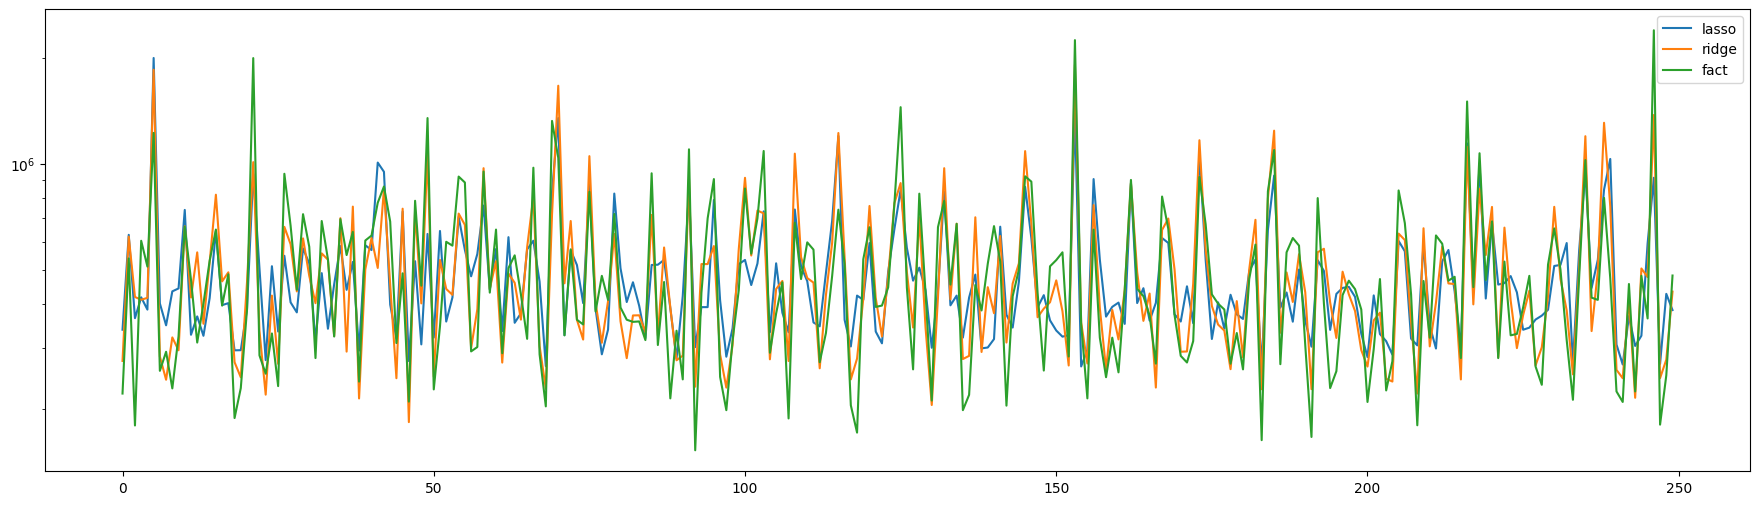

In [271]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

plt.plot(range(250), np.exp(lasso.predict(X.iloc[:250, ])), label = 'lasso')
plt.plot(range(250), np.exp(ridge.predict(X.iloc[:250, ])), label = 'ridge')
plt.plot(range(250), y.iloc[:250, ], label = 'fact')
plt.yscale('log')
plt.legend()
print(f'Lasso score = {r2_score(y, np.exp(lasso.predict(X)))}')
print(f'Ridge score = {r2_score(y, np.exp(ridge.predict(X)))}')

## Вывод: Ridge приемлема

# Пробуем увеличить результат с помощью подбора scaler и методов машинного обучения

In [272]:
df = pd.read_csv('data_res.csv', index_col = 'Unnamed: 0')
df.head()

,цена,количество спален,количество ванных комнат,жилая площадь (кв. футы),площадь участка (кв. футы),количество этажей,"водная поверхность (1, если дом находится на берегу, иначе 0)",вид на собственность (от 0 до 4),состояние объекта (от 1 до 5),класс объекта (от 1 до 13),площадь над уровнем земли (кв. футы),площадь подвала (кв. футы),год постройки,год реновации,почтовый индекс,широта,долгота,средняя жилая площадь ближайших 15 соседей (кв. футы),средняя площадь участков ближайших 15 соседей (кв. футы)
0,221900.000000,3.000000,1.000000,1180.000000,5650.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1955.000000,0.000000,98178.000000,47.511200,-122.257000,1340.000000,5650.000000
1,538000.000000,3.000000,2.250000,2570.000000,7242.000000,2.000000,0.000000,0.000000,3.000000,7.000000,2170.000000,400.000000,1951.000000,1991.000000,98125.000000,47.721000,-122.319000,1690.000000,7639.000000
2,180000.000000,2.000000,1.000000,770.000000,10000.000000,1.000000,0.000000,0.000000,3.000000,6.000000,770.000000,0.000000,1933.000000,0.000000,98028.000000,47.737900,-122.233000,2720.000000,8062.000000
3,604000.000000,4.000000,3.000000,1960.000000,5000.000000,1.000000,0.000000,0.000000,5.000000,7.000000,1050.000000,910.000000,1965.000000,0.000000,98136.000000,47.520800,-122.393000,1360.000000,5000.000000
4,510000.000000,3.000000,2.000000,1680.000000,8080.000000,1.000000,0.000000,0.000000,3.000000,8.000000,1680.000000,0.000000,1987.000000,0.000000,98074.000000,47.616800,-122.045000,1800.000000,7503.000000


In [273]:
df.fillna('error', inplace = True)

In [274]:
def encode_categorial(name_scaler, scaler, data, y = None, return_scaler = False):
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler
    
def encode_number(name_scaler, scaler, data, return_scaler = False):
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler

In [275]:

scalers_categorial = {'LabelEncoder': LabelEncoder(), 
                     'TargetEncoder': TargetEncoder()}

mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'Ridge': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler(),
           'RobustScaler': RobustScaler(), 'Normalizer': Normalizer(), 'Not scaled': 0}

mlss = []

X = df.drop(['цена'], axis = 1)
y = df['цена']

numbers_cols, categorical_cols = get_cols(X)

for idd, (name_ml, ml) in enumerate(mls.items()):
    data = pd.DataFrame()
    for ide, (name_scaler_categorial, scaler_categorial) in enumerate(scalers_categorial.items()):
        data[categorical_cols] = encode_categorial(name_scaler_categorial, scaler_categorial, X[categorical_cols], y)
        
        for name_scaler, scaler in scalers.items():
            for name in numbers_cols:
                data[name] = 0
            
            data[numbers_cols] = encode_number(name_scaler, scaler, X[numbers_cols])

            
            X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42, shuffle = True)
        
            model = ml.fit(X_train, y_train)
        
            #mlss[name+ ' '+ str(ide)] = {'categorial encoding': i,'number encoding': name_scaler,
            #                            'score': round(model.score(X_test, y_test),3)}
            mlss.append([name_ml, name_scaler_categorial, name_scaler, round(model.score(X_test, y_test),3)])

In [276]:
sorted(mlss, key = lambda x: x[3], reverse = True)

[['GradientBoostingRegressor', 'LabelEncoder', 'StandardScaler', 0.858],
 ['GradientBoostingRegressor', 'LabelEncoder', 'MinMaxScaler', 0.858],
 ['GradientBoostingRegressor', 'LabelEncoder', 'RobustScaler', 0.858],
 ['GradientBoostingRegressor', 'LabelEncoder', 'Not scaled', 0.858],
 ['GradientBoostingRegressor', 'TargetEncoder', 'StandardScaler', 0.858],
 ['GradientBoostingRegressor', 'TargetEncoder', 'MinMaxScaler', 0.858],
 ['GradientBoostingRegressor', 'TargetEncoder', 'RobustScaler', 0.858],
 ['GradientBoostingRegressor', 'TargetEncoder', 'Not scaled', 0.858],
 ['ExtraTreesRegressor', 'LabelEncoder', 'Not scaled', 0.854],
 ['ExtraTreesRegressor', 'TargetEncoder', 'Not scaled', 0.854],
 ['ExtraTreesRegressor', 'LabelEncoder', 'StandardScaler', 0.851],
 ['ExtraTreesRegressor', 'LabelEncoder', 'MinMaxScaler', 0.851],
 ['ExtraTreesRegressor', 'LabelEncoder', 'RobustScaler', 0.851],
 ['ExtraTreesRegressor', 'TargetEncoder', 'StandardScaler', 0.851],
 ['ExtraTreesRegressor', 'TargetEnco

## Как мы можем заметить нам лучше всего использовать GradientBoostingRegressor